# Importing libraries, loading and transforming data

In [1]:

!pip install -U -q mlflow datasets>=2.14.5 nlp 2>/dev/null

In [6]:
import pandas as pd  
import gc  
import re  
import numpy as np  

import warnings 
warnings.filterwarnings("ignore")  

import torch  
from transformers import AutoModel, AutoTokenizer 
from transformers import TextDataset, LineByLineTextDataset, DataCollatorForLanguageModeling, \
pipeline, Trainer, TrainingArguments, DataCollatorWithPadding  
from transformers import AutoModelForSequenceClassification  

from nlp import Dataset  
from imblearn.over_sampling import RandomOverSampler  
import datasets  
from datasets import Dataset, Image, ClassLabel 
from transformers import pipeline  
from bs4 import BeautifulSoup 

import matplotlib.pyplot as plt  
import itertools  
from sklearn.metrics import (  
    accuracy_score,  
    roc_auc_score, 
    confusion_matrix, 
    classification_report, 
    f1_score  
)

from datasets import load_metric  

from tqdm import tqdm  
tqdm.pandas() 

In [7]:

train_fraction = 0.8

num_train_epochs = 10

learning_rate = 3e-7

train_batch_size = 8

eval_batch_size = 64

warmup_steps = 50

weight_decay = 0.02

BERT_MODEL = "distilbert-base-cased"

output_dir = "sms-spam-detection-distilbert"

In [8]:
iswpadf=pd.read_csv("/kaggle/input/iswpa-dataset/IWSPA-AP-Parsed.csv", encoding='latin-1')
iswpadf = iswpadf.rename(columns={'is_phishing': 'label', 'email_body': 'title'}) # Rename the columns to standard ones
iswpadf

df_1 = iswpadf[iswpadf['label'] == 1]
df_0 = iswpadf[iswpadf['label'] == 0]

sample_size_1 = int(len(df_1) * 0.20)
sample_size_0 = int(len(df_0) * 0.20)

sampled_1 = df_1.sample(sample_size_1)
sampled_0 = df_0.sample(sample_size_0)

new_df = pd.concat([sampled_1, sampled_0])
new_df=new_df[['label', 'title']]


In [9]:
%%time
df = pd.read_csv("/kaggle/input/radev-data/fraud_email_.csv", encoding='latin-1')
df = df.rename(columns={'Class': 'label', 'Text': 'title'}) 

df=pd.concat([df,new_df])
print(df)
item0 = df.shape[0] 
df = df.drop_duplicates() 
item1 = df.shape[0] 
print(f"There are {item0-item1} duplicates found in the dataset") 

df = df.rename(columns={'Class': 'label', 'Text': 'title'})

df = df[['label', 'title']] 
df['label'] = df['label'].astype('str')


df = df[~df['title'].isnull()] 
df = df[~df['label'].isnull()]  
print(df.shape)  
df.sample(5).T  



                                                  title  label
0     Supply Quality China's EXCLUSIVE dimensions at...      1
1                            over. SidLet me know. Thx.      0
2     Dear Friend,Greetings to you.I wish to accost ...      1
3     MR. CHEUNG PUIHANG SENG BANK LTD.DES VOEUX RD....      1
4             Not a surprising assessment from Embassy.      0
...                                                 ...    ...
5324  Ciao Ale, grazie mille. Buona giornata. ciao A...      0
2412  Hey gang, we're looking for coverage of Jake H...      0
2221  Outgoing call to +1 (202) 738-0059 (Other) +1 ...      0
9915  <x-flowed> Dear Eystein and Peck, sorry for th...      0
9654  In Honor of the Nov. 9th National Socialist Ma...      0

[13987 rows x 2 columns]
There are 1761 duplicates found in the dataset
(12225, 2)
CPU times: user 170 ms, sys: 14 ms, total: 184 ms
Wall time: 183 ms


,3250,2401,8826,6393,8037
label,1,0,0,0,0
title,<DIV><DIV><DIV><STRONG><STRONG><STRONG><STRONG...,I talked w him and will download tomorrow.,B6Thursday January 5 2012 12:26 PMH: latest in...,Yes I will get on it.,Latest from Gene.


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12225 entries, 0 to 9654
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   12225 non-null  object
 1   title   12225 non-null  object
dtypes: object(2)
memory usage: 286.5+ KB


In [11]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(df[['label']])

print(classes)

weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['label'])

class_weights = dict(zip(classes, weights))

print(class_weights)

['0' '1']
{'0': 0.79620945681907, '1': 1.3439973614775726}


In [12]:
labels_list = sorted(list(df['label'].unique()))

label2id, id2label = dict(), dict()

for i, label in enumerate(labels_list):
    label2id[label] = i 
    id2label[i] = label  

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: '0', 1: '1'} 

Mapping of Labels to IDs: {'0': 0, '1': 1}


In [13]:
ordered_weigths = [class_weights[x] for x in id2label.values()]
ordered_weigths

[0.79620945681907, 1.3439973614775726]

In [14]:
dataset = Dataset.from_pandas(df)

In [15]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=1-train_fraction, shuffle=True) 

df_train = dataset['train']

df_test = dataset['test']

Map:   0%|          | 0/12225 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/12225 [00:00<?, ? examples/s]

In [16]:
del df

gc.collect()

243

In [17]:

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, use_fast=True, low_cpu_mem_usage=False)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [18]:


def preprocess_function(examples):
   
    return tokenizer(examples["title"], truncation=True)

df_train = df_train.map(preprocess_function, batched=True)
df_test = df_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/9780 [00:00<?, ? examples/s]

Map:   0%|          | 0/2445 [00:00<?, ? examples/s]

In [19]:
df_train = df_train.remove_columns(['title'])

df_test = df_test.remove_columns(['title'])

In [20]:
df_train

Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 9780
})

In [21]:
df_test

Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2445
})

In [22]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [23]:
tokenizer.decode(df_train[0]['input_ids'])

'[CLS] Sir, Accept my apologies for writing to you in this mode for it might be of inconvenience to you but due to my quest for an honest and reliable international assistance concerning a business here in my country Nigeria I have no other option than to go this length. I need the effectiveness of your professionalism in accomplishing this very business. I am DR. MOHAMMED BELLO Director / coordinator Forex and computer operations department of the Afex Bank of Africa PLC. I am writing this letter to ask your support and cooperation to carry out this business opportunity in my department. We discovered an abandoned sum of $ 42. 500, 000. 00 ( forty two million, Five hundred thousand United States Dollars ) in an account that belongs to one of our customer in Afex Bank of Nigeria, Late Monsieur. Ives Laurent ( a French citizen and an Engineer executing major Federal contract with governments of West African sub region ). He died with a fellow business associate in a ghastly auto crash l

# Loading and training model

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=len(labels_list),
    output_attentions=False,  
    output_hidden_states=False  
)

model.config.id2label = id2label  
model.config.label2id = label2id  

print(model.num_parameters(only_trainable=True) / 1e6)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


65.783042


In [25]:
metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = metric.compute(predictions=predictions, references=labels)
    
    return accuracy

In [26]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(ordered_weigths, device=model.device).float())
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [27]:
# Create TrainingArguments to configure the training process
training_args = TrainingArguments(
    output_dir=output_dir,  # Directory to save the model checkpoints and logs
    logging_dir='./logs',  # Directory to store training logs
    num_train_epochs=num_train_epochs,  # Number of training epochs
    per_device_train_batch_size=train_batch_size,  # Batch size for training data
    per_device_eval_batch_size=eval_batch_size,  # Batch size for evaluation data
    logging_strategy='steps',  # Logging frequency during training (steps or epoch)
    logging_first_step=True,  # Log the first training step
    load_best_model_at_end=True,  # Load the best model at the end of training
    logging_steps=1,  # Log every training step (useful for debugging)
    learning_rate=learning_rate, # Set the learning rate for the optimizer.
    evaluation_strategy='epoch',  # Evaluation frequency (epoch or steps)
    warmup_steps=warmup_steps,  # Number of warmup steps for the learning rate
    weight_decay=weight_decay,  # Weight decay for regularization
    eval_steps=1,  # Evaluate every training step (useful for debugging)
    save_strategy='epoch',  # Save model checkpoints every epoch
    save_total_limit=1,  # Limit the number of saved checkpoints to save space
    report_to="mlflow",  # Log training metrics to MLflow
)


trainer = WeightedTrainer(
    model=model,  # The pretrained or custom model to be trained
    args=training_args,  # TrainingArguments for configuring training
    compute_metrics=compute_metrics,  # Function for computing evaluation metrics
    train_dataset=df_train,  # Training dataset
    eval_dataset=df_test,  # Evaluation dataset
    data_collator=data_collator  # Data collator for batching and preprocessing
)

In [28]:
trainer.evaluate()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.700161337852478,
 'eval_accuracy': 0.6265848670756646,
 'eval_runtime': 24.9301,
 'eval_samples_per_second': 98.074,
 'eval_steps_per_second': 1.564}

In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.434900,0.344561,0.907566
2,0.467900,0.218107,0.941922
3,0.882100,0.152759,0.955010
4,0.020800,0.121247,0.963599
5,0.263000,0.101931,0.970552
6,0.007700,0.091590,0.974233
7,0.003000,0.086196,0.976687
8,0.033000,0.084211,0.978732
9,0.090900,0.082801,0.979550
10,0.002800,0.082558,0.979141


TrainOutput(global_step=12230, training_loss=0.17084757430303404, metrics={'train_runtime': 3016.2734, 'train_samples_per_second': 32.424, 'train_steps_per_second': 4.055, 'total_flos': 1.2623431079649024e+16, 'train_loss': 0.17084757430303404, 'epoch': 10.0})

In [33]:
trainer.evaluate()

{'eval_loss': 0.08255771547555923,
 'eval_accuracy': 0.9791411042944785,
 'eval_runtime': 23.5504,
 'eval_samples_per_second': 103.82,
 'eval_steps_per_second': 1.656,
 'epoch': 10.0}

In [34]:
outputs = trainer.predict(df_test)

print(outputs.metrics)

{'test_loss': 0.08255771547555923, 'test_accuracy': 0.9791411042944785, 'test_runtime': 23.1507, 'test_samples_per_second': 105.613, 'test_steps_per_second': 1.685}


Accuracy: 0.9791
F1 Score: 0.9776


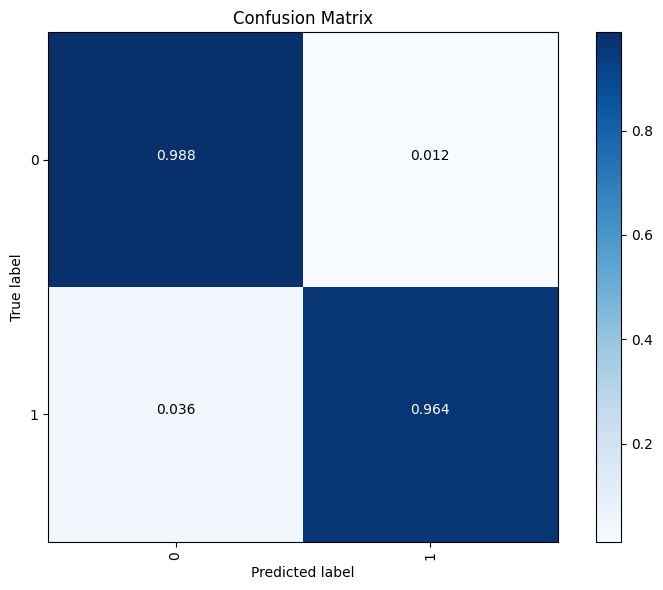


Classification report:

              precision    recall  f1-score   support

           0     0.9787    0.9883    0.9834      1532
           1     0.9800    0.9639    0.9718       913

    accuracy                         0.9791      2445
   macro avg     0.9793    0.9761    0.9776      2445
weighted avg     0.9791    0.9791    0.9791      2445



In [35]:
y_true = outputs.label_ids

y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
    
    plt.figure(figsize=figsize)
    
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 120:
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

# Saving the model and checking its performance with a sample input

In [36]:
trainer.save_model()

In [37]:
tokenizer.save_vocabulary(save_directory=f"./{output_dir}")

('./sms-spam-detection-distilbert/vocab.txt',)

In [38]:
pipe = pipeline("text-classification", output_dir, tokenizer=BERT_MODEL)
sample_title = '''Elon Musk buys Twitter, and so can you'''
pipe(sample_title, top_k=10)

[{'label': '0', 'score': 0.9966498017311096},
 {'label': '1', 'score': 0.003350190818309784}]

In [40]:
%%time
df = pd.read_csv("/kaggle/input/iswpa-dataset/IWSPA-AP-Parsed.csv", encoding='latin-1')

item0 = df.shape[0]  
df = df.drop_duplicates() 
item1 = df.shape[0]  
print(f"There are {item0-item1} duplicates found in the dataset") 

df = df.rename(columns={'is_phishing': 'label', 'email_body': 'title'}) 

df = df[['label', 'title']] 
df['label'] = df['label'].astype('str')


df = df[~df['title'].isnull()]  
df = df[~df['label'].isnull()] 

print(df.shape) 
df.sample(5).T  

There are 1019 duplicates found in the dataset
(9275, 2)
CPU times: user 220 ms, sys: 20 ms, total: 240 ms
Wall time: 242 ms


,1384,5288,5840,7103,1073
label,0,0,0,0,0
title,Finance Guest Account (GUEST)'s trip approval ...,"ST. 1st Class Herring, Its not a problem, I ca...","""Thanks"" Ben for this, hi all and happy new ye...",fatto Da: Lucia Rana [mailto:l.rana@hackingtea...,To be automatically unsubscribed from this lis...


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9275 entries, 0 to 10295
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9275 non-null   object
 1   title   9275 non-null   object
dtypes: object(2)
memory usage: 217.4+ KB


In [42]:
dataset = Dataset.from_pandas(df)

In [43]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=1, shuffle=True) # , stratify_by_column="label"

df_train = dataset['train']

df_test = dataset['test']

Map:   0%|          | 0/9275 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9275 [00:00<?, ? examples/s]

In [44]:

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, use_fast=True, low_cpu_mem_usage=False)

In [45]:

def preprocess_function(examples):
   
    return tokenizer(examples["title"], truncation=True)

df_train = df_train.map(preprocess_function, batched=True)
df_test = df_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/9274 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [46]:
df_train = df_train.remove_columns(['title'])

df_test = df_test.remove_columns(['title'])

In [47]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [48]:
tokenizer.decode(df_train[0]['input_ids'])

'[CLS] Alessandro Scarafile updated a event in the 00. TENTATIVE calendar Jan 2013, 2015 Until Jan 2114, 2015 Support Morocco ( ALFAHAD ) Client needs help for firewall configuration and system check. Refer to ticket YMN - 265 - 89975. You are receiving this notification because you are watching the following : 00. TENTATIVE Sent by Atlassian Confluence 5. 6. 3, the Enterprise Wiki [SEP]'

In [49]:
outputs = trainer.predict(df_train)

print(outputs.metrics)

{'test_loss': 0.32046690583229065, 'test_accuracy': 0.9346560276040543, 'test_runtime': 89.1329, 'test_samples_per_second': 104.047, 'test_steps_per_second': 1.627}


Accuracy: 0.9347
F1 Score: 0.8324


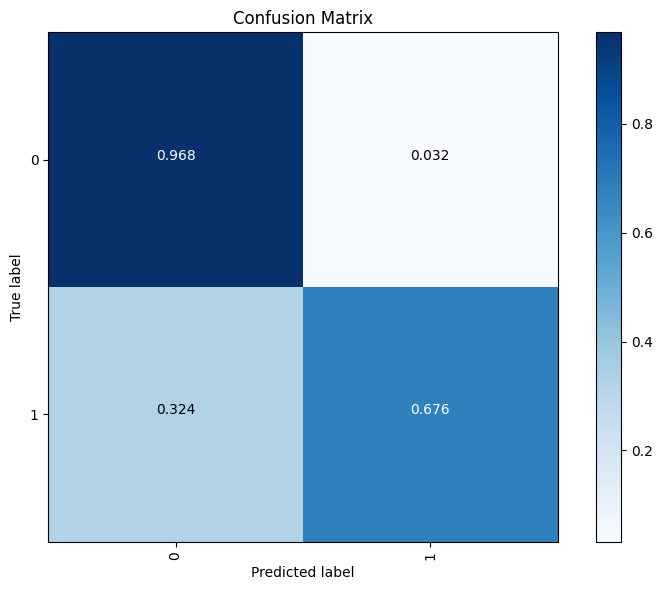


Classification report:

              precision    recall  f1-score   support

           0     0.9588    0.9679    0.9633      8220
           1     0.7295    0.6755    0.7015      1054

    accuracy                         0.9347      9274
   macro avg     0.8441    0.8217    0.8324      9274
weighted avg     0.9327    0.9347    0.9336      9274



In [50]:
y_true = outputs.label_ids

y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
   
    plt.figure(figsize=figsize)
    
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 120:
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))